In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sqlalchemy import create_engine
from imblearn.under_sampling import RandomUnderSampler

# Set seed for reproducibility
np.random.seed(42)

# Database connection setup
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

# Step 1: Load data from PostgreSQL
query = 'SELECT * FROM public.updated_overall_cleaned_data;'
data = pd.read_sql(query, con=engine)

# Updated selected columns
selected_columns = [
    'policy no', 'policy start date', 'policy end date', 'biztype', 'tie up', 'variant', 'Cleaned Reg no', 'model',
    'rto location', 'product name', 'Cleaned Branch Name 2', 'Renewal Rate Status',
    'Cleaned State2', 'discount_level', 'cleaned new vertical', 'purchase_type',
    'manufacturer/make', 'tie_up_category', 'make_category', 'Cleaned Zone 2',
    'corrected_name', 'payement_level', 'New Customers', 'fuel type', 'customerid',
    'add-on_level', 'vertical_category', 'vehicle segment', 'idv_level', 'vehicle_type',
    'Claim Status', 'Claim Happaned/Not', 'Area Type', 'ncb % previous year',
    'total od premium', 'applicable discount with ncb', 'policy_wise_purchase',
    'age', 'total tp premium', 'total premium payable',
    'gst', 'vehicle idv', 'Policy Tenure', 'Number of claims', 'denied', 'approved', 'Customer Tenure',
    'before gst add-on gwp', 'Policy Status'
]

data = data[selected_columns]

# Remove rows where 'Policy Status' contains 'Open'
data = data[data['Policy Status'].isin(['Renewed', 'Not Renewed'])]

data['Policy Status'] = data['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

# Convert date columns to datetime
date_columns = ['policy start date', 'policy end date']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Drop date columns after splitting
data = data.drop(columns=date_columns)

# Define features and target
features = [col for col in data.columns if col not in ['Policy Status']]

# Define X (features) and y (target)
X = data[features]
y = data['Policy Status']

# Splitting the data with a 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [2]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

In [3]:
# Generate 7 different undersampled datasets while keeping the minority class constant
undersampled_sets = {}
for i in range(7):
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=i)  
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    undersampled_sets[f'set_{i+1}'] = (X_resampled, y_resampled)

# Access specific undersampled sets
X_train_1, y_train_1 = undersampled_sets["set_1"]
X_train_2, y_train_2 = undersampled_sets["set_2"]
X_train_3, y_train_3 = undersampled_sets["set_3"]
X_train_4, y_train_4 = undersampled_sets["set_4"]
X_train_5, y_train_5 = undersampled_sets["set_5"]
X_train_6, y_train_6 = undersampled_sets["set_6"]
X_train_7, y_train_7 = undersampled_sets["set_7"]

In [4]:
# Print count of 0s and 1s in each undersampled set
for i in range(1, 8):
    _, y_resampled = undersampled_sets[f'set_{i}']
    print(f"Set {i}:\n{y_resampled.value_counts()}\n")

Set 1:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 2:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 3:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 4:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 5:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 6:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 7:
Policy Status
0    388763
1    388763
Name: count, dtype: int64



In [5]:
# Print count of 0s and 1s in X_train and y_train
print("Training Set Counts:")
print(y_train.value_counts())
print()

# Print count of 0s and 1s in X_test and y_test
print("Test Set Counts:")
print(y_test.value_counts())
print()

Training Set Counts:
Policy Status
1    663346
0    388763
Name: count, dtype: int64

Test Set Counts:
Policy Status
1    284292
0    166613
Name: count, dtype: int64




========== Ensemble Metrics for Undersampled Set 1 ==========
----- Test Data Metrics -----
Test Accuracy: 0.7181
Test Log Loss: 0.5466
Test ROC AUC: 0.7910
Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.71      0.65    166613
           1       0.81      0.72      0.76    284292

    accuracy                           0.72    450905
   macro avg       0.71      0.72      0.71    450905
weighted avg       0.73      0.72      0.72    450905

Test Confusion Matrix:
[[118912  47701]
 [ 79430 204862]]
Class 0 Test Accuracy: 0.7137
Class 1 Test Accuracy: 0.7206


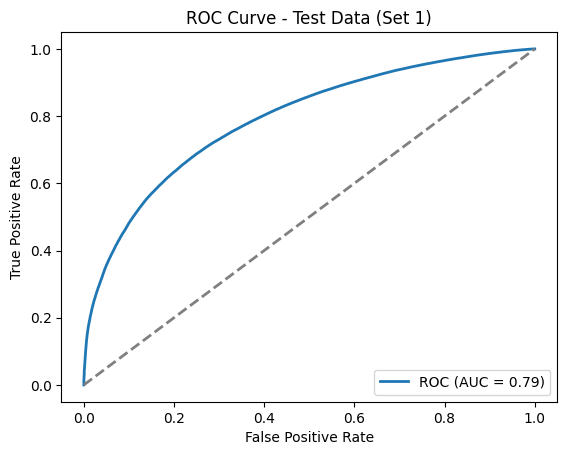


----- Training Data Metrics -----
Train Accuracy: 0.7269
Train Log Loss: 0.5339
Train ROC AUC: 0.8160
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307427  81336]
 [205993 457353]]
Class 0 Train Accuracy: 0.7908
Class 1 Train Accuracy: 0.6895


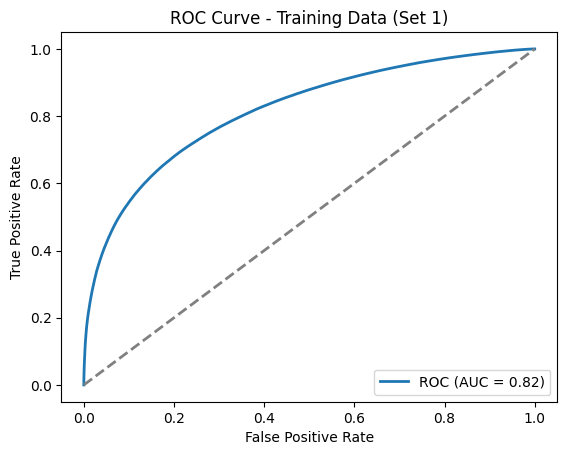


========== Ensemble Metrics for Undersampled Set 2 ==========
----- Test Data Metrics -----
Test Accuracy: 0.7178
Test Log Loss: 0.5457
Test ROC AUC: 0.7879
Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.69      0.64    166613
           1       0.80      0.73      0.77    284292

    accuracy                           0.72    450905
   macro avg       0.70      0.71      0.70    450905
weighted avg       0.73      0.72      0.72    450905

Test Confusion Matrix:
[[114819  51794]
 [ 75445 208847]]
Class 0 Test Accuracy: 0.6891
Class 1 Test Accuracy: 0.7346


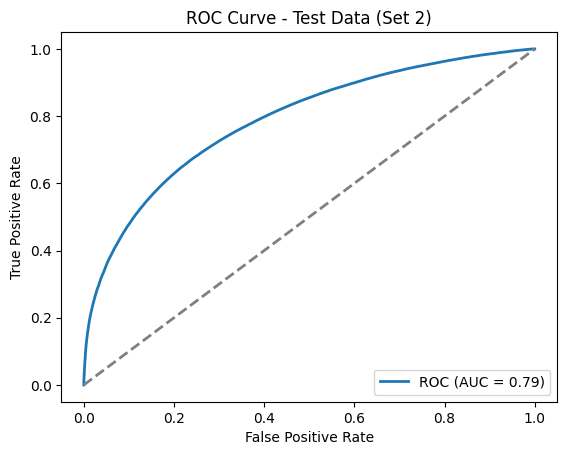


----- Training Data Metrics -----
Train Accuracy: 0.7266
Train Log Loss: 0.5340
Train ROC AUC: 0.8159
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307621  81142]
 [206522 456824]]
Class 0 Train Accuracy: 0.7913
Class 1 Train Accuracy: 0.6887


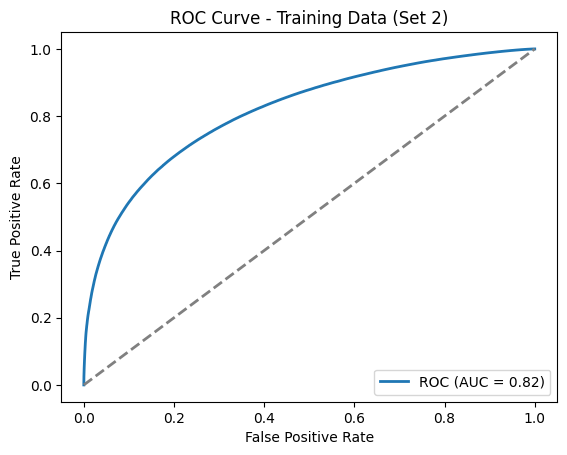


========== Ensemble Metrics for Undersampled Set 3 ==========
----- Test Data Metrics -----
Test Accuracy: 0.7168
Test Log Loss: 0.5460
Test ROC AUC: 0.7879
Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.69      0.64    166613
           1       0.80      0.73      0.77    284292

    accuracy                           0.72    450905
   macro avg       0.70      0.71      0.70    450905
weighted avg       0.73      0.72      0.72    450905

Test Confusion Matrix:
[[115041  51572]
 [ 76144 208148]]
Class 0 Test Accuracy: 0.6905
Class 1 Test Accuracy: 0.7322


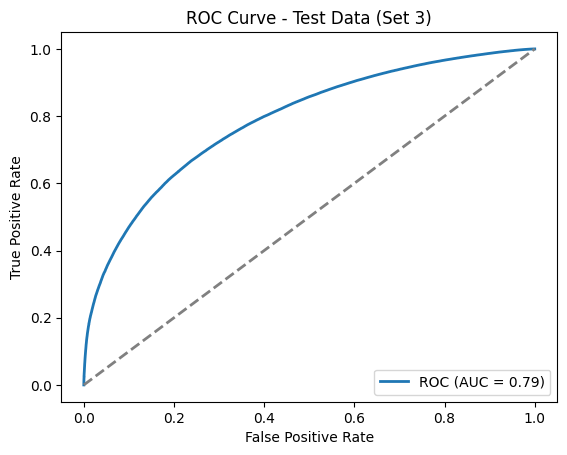


----- Training Data Metrics -----
Train Accuracy: 0.7267
Train Log Loss: 0.5343
Train ROC AUC: 0.8156
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307122  81641]
 [205899 457447]]
Class 0 Train Accuracy: 0.7900
Class 1 Train Accuracy: 0.6896


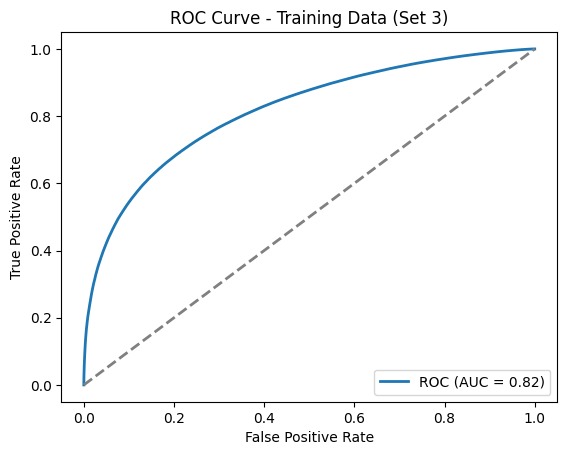


========== Ensemble Metrics for Undersampled Set 4 ==========
----- Test Data Metrics -----
Test Accuracy: 0.7202
Test Log Loss: 0.5431
Test ROC AUC: 0.7926
Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.70      0.65    166613
           1       0.81      0.73      0.77    284292

    accuracy                           0.72    450905
   macro avg       0.71      0.72      0.71    450905
weighted avg       0.73      0.72      0.72    450905

Test Confusion Matrix:
[[116768  49845]
 [ 76331 207961]]
Class 0 Test Accuracy: 0.7008
Class 1 Test Accuracy: 0.7315


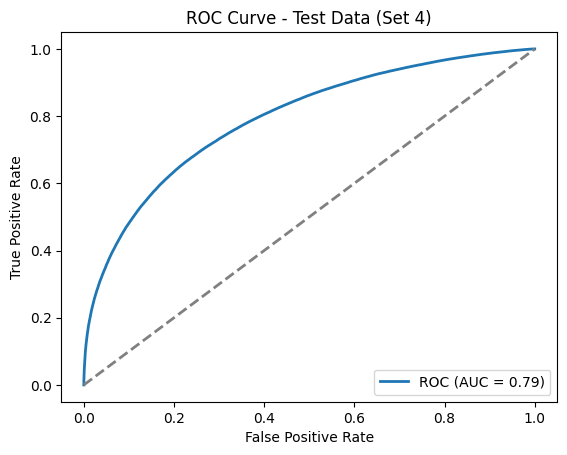


----- Training Data Metrics -----
Train Accuracy: 0.7270
Train Log Loss: 0.5340
Train ROC AUC: 0.8160
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307588  81175]
 [206087 457259]]
Class 0 Train Accuracy: 0.7912
Class 1 Train Accuracy: 0.6893


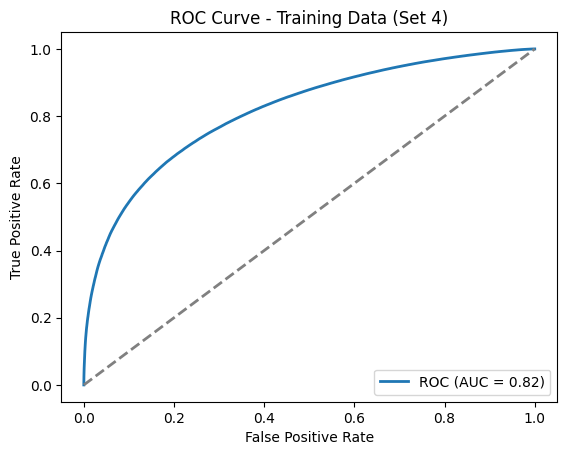


========== Ensemble Metrics for Undersampled Set 5 ==========
----- Test Data Metrics -----
Test Accuracy: 0.7201
Test Log Loss: 0.5435
Test ROC AUC: 0.7896
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.69      0.64    166613
           1       0.80      0.74      0.77    284292

    accuracy                           0.72    450905
   macro avg       0.70      0.71      0.71    450905
weighted avg       0.73      0.72      0.72    450905

Test Confusion Matrix:
[[114421  52192]
 [ 73994 210298]]
Class 0 Test Accuracy: 0.6867
Class 1 Test Accuracy: 0.7397


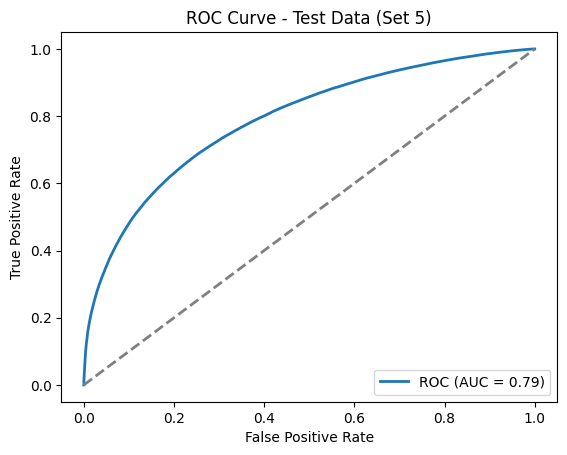


----- Training Data Metrics -----
Train Accuracy: 0.7264
Train Log Loss: 0.5342
Train ROC AUC: 0.8157
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307309  81454]
 [206379 456967]]
Class 0 Train Accuracy: 0.7905
Class 1 Train Accuracy: 0.6889


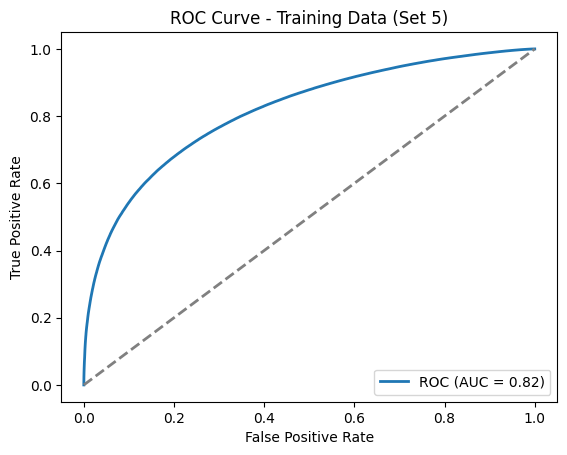


========== Ensemble Metrics for Undersampled Set 6 ==========
----- Test Data Metrics -----
Test Accuracy: 0.7191
Test Log Loss: 0.5431
Test ROC AUC: 0.7888
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.68      0.64    166613
           1       0.80      0.74      0.77    284292

    accuracy                           0.72    450905
   macro avg       0.70      0.71      0.71    450905
weighted avg       0.73      0.72      0.72    450905

Test Confusion Matrix:
[[113177  53436]
 [ 73204 211088]]
Class 0 Test Accuracy: 0.6793
Class 1 Test Accuracy: 0.7425


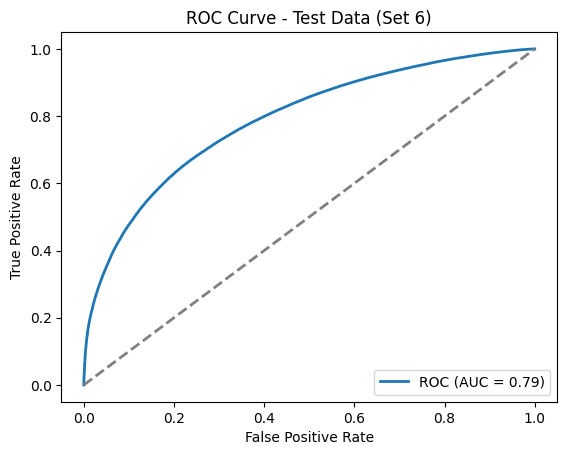


----- Training Data Metrics -----
Train Accuracy: 0.7270
Train Log Loss: 0.5341
Train ROC AUC: 0.8158
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307126  81637]
 [205623 457723]]
Class 0 Train Accuracy: 0.7900
Class 1 Train Accuracy: 0.6900


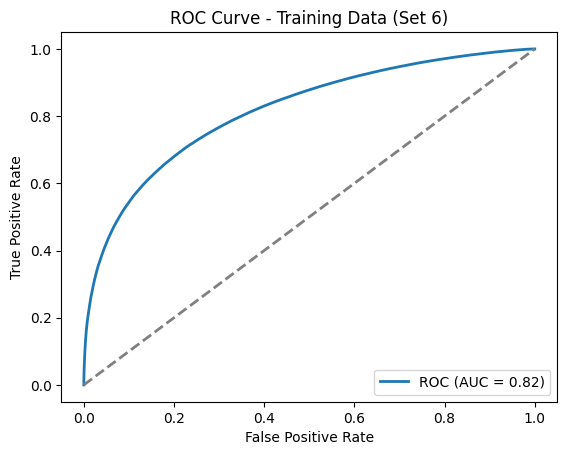


========== Ensemble Metrics for Undersampled Set 7 ==========
----- Test Data Metrics -----
Test Accuracy: 0.7242
Test Log Loss: 0.5385
Test ROC AUC: 0.7919
Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.67      0.64    166613
           1       0.79      0.76      0.78    284292

    accuracy                           0.72    450905
   macro avg       0.71      0.71      0.71    450905
weighted avg       0.73      0.72      0.73    450905

Test Confusion Matrix:
[[110856  55757]
 [ 68609 215683]]
Class 0 Test Accuracy: 0.6654
Class 1 Test Accuracy: 0.7587


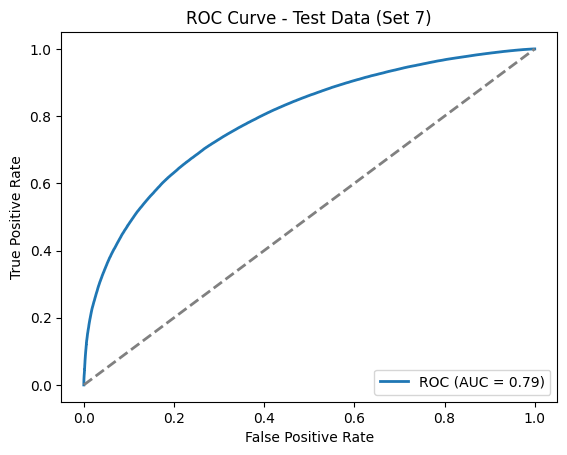


----- Training Data Metrics -----
Train Accuracy: 0.7269
Train Log Loss: 0.5339
Train ROC AUC: 0.8160
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307976  80787]
 [206536 456810]]
Class 0 Train Accuracy: 0.7922
Class 1 Train Accuracy: 0.6886


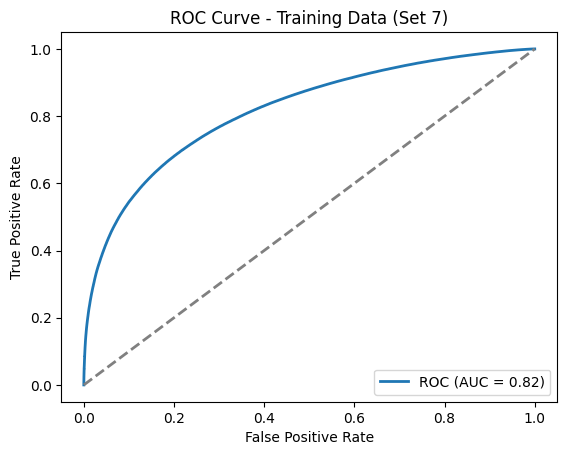

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Define custom weights
weight_1 = 0.45  # RandomForest, good for class 0
weight_2 = 0.55  # CatBoost, good for class 1

# Loop over 7 undersampled sets
for i in range(1, 8):
    print(f"\n========== Ensemble Metrics for Undersampled Set {i} ==========")
    
    # Get the i-th undersampled training set
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    
    # Train the two models on this undersampled set
    model_1 = RandomForestClassifier(random_state=42, max_depth=10)
    model_2 = CatBoostClassifier(depth=10, learning_rate=0.1, iterations=500, 
                                 random_seed=42, verbose=0)
    model_1.fit(X_train_set, y_train_set)
    model_2.fit(X_train_set, y_train_set)
    
    # -------------------------------
    # Evaluate on Test Data
    # -------------------------------
    # Get probability predictions on test data
    probs_1_test = model_1.predict_proba(X_test)
    probs_2_test = model_2.predict_proba(X_test)
    
    # Compute weighted probabilities for test data
    weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
    
    # Final predictions: for binary classification, argmax gives the predicted class.
    y_pred = np.argmax(weighted_probs_test, axis=1)
    y_pred_proba = weighted_probs_test[:, 1]  # probability for class 1
    
    # Compute metrics on test data
    test_accuracy = accuracy_score(y_test, y_pred)
    test_log_loss = log_loss(y_test, y_pred_proba)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    test_report = classification_report(y_test, y_pred)
    test_conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Compute class-specific accuracy for test data
    class0_acc_test = (test_conf_matrix[0, 0] / np.sum(test_conf_matrix[0, :])
                       if np.sum(test_conf_matrix[0, :]) != 0 else 0)
    class1_acc_test = (test_conf_matrix[1, 1] / np.sum(test_conf_matrix[1, :])
                       if np.sum(test_conf_matrix[1, :]) != 0 else 0)
    
    print("----- Test Data Metrics -----")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Log Loss: {test_log_loss:.4f}")
    print(f"Test ROC AUC: {test_roc_auc:.4f}")
    print("Test Classification Report:")
    print(test_report)
    print("Test Confusion Matrix:")
    print(test_conf_matrix)
    print(f"Class 0 Test Accuracy: {class0_acc_test:.4f}")
    print(f"Class 1 Test Accuracy: {class1_acc_test:.4f}")
    
    # Plot ROC curve for test data
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Test Data (Set {i})')
    plt.legend(loc="lower right")
    plt.show()
    
    # -------------------------------
    # Evaluate on Training Data (Full Training Set)
    # -------------------------------
    # Get probability predictions on full training data
    probs_1_train = model_1.predict_proba(X_train)
    probs_2_train = model_2.predict_proba(X_train)
    
    # Compute weighted probabilities for training data
    weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)
    
    y_train_pred = np.argmax(weighted_probs_train, axis=1)
    y_train_pred_proba = weighted_probs_train[:, 1]
    
    # Compute metrics on training data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_log_loss = log_loss(y_train, y_train_pred_proba)
    train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
    train_report = classification_report(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    
    # Compute class-specific accuracy for training data
    class0_acc_train = (train_conf_matrix[0, 0] / np.sum(train_conf_matrix[0, :])
                        if np.sum(train_conf_matrix[0, :]) != 0 else 0)
    class1_acc_train = (train_conf_matrix[1, 1] / np.sum(train_conf_matrix[1, :])
                        if np.sum(train_conf_matrix[1, :]) != 0 else 0)
    
    print("\n----- Training Data Metrics -----")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Log Loss: {train_log_loss:.4f}")
    print(f"Train ROC AUC: {train_roc_auc:.4f}")
    print("Train Classification Report:")
    print(train_report)
    print("Train Confusion Matrix:")
    print(train_conf_matrix)
    print(f"Class 0 Train Accuracy: {class0_acc_train:.4f}")
    print(f"Class 1 Train Accuracy: {class1_acc_train:.4f}")
    
    # Plot ROC curve for training data
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    plt.figure()
    plt.plot(fpr_train, tpr_train, lw=2, label=f'ROC (AUC = {train_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Training Data (Set {i})')
    plt.legend(loc="lower right")
    plt.show()


========== Ensemble Metrics for Undersampled Set 1 ==========
----- Test Data Metrics (Default 0.5 Threshold) -----
Test Accuracy: 0.7181
Test Log Loss: 0.5466
Test ROC AUC: 0.7910
Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.71      0.65    166613
           1       0.81      0.72      0.76    284292

    accuracy                           0.72    450905
   macro avg       0.71      0.72      0.71    450905
weighted avg       0.73      0.72      0.72    450905

Test Confusion Matrix:
[[118912  47701]
 [ 79430 204862]]
Class 0 Test Accuracy: 0.7137
Class 1 Test Accuracy: 0.7206


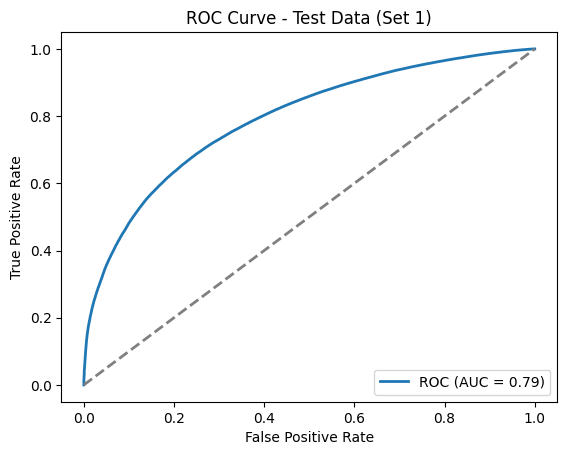

Threshold where Sensitivity = Specificity (Test Data): 0.5024
----- Test Data Metrics (Sens=Spec Threshold) -----
Test Accuracy: 0.7174
Test Confusion Matrix:
[[119526  47087]
 [ 80344 203948]]
Sensitivity (Recall for class 1): 0.7174
Specificity (Recall for class 0): 0.7174

----- Training Data Metrics (Default 0.5 Threshold) -----
Train Accuracy: 0.7269
Train Log Loss: 0.5339
Train ROC AUC: 0.8160
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307427  81336]
 [205993 457353]]
Class 0 Train Accuracy: 0.7908
Class 1 Train Accuracy: 0.6895


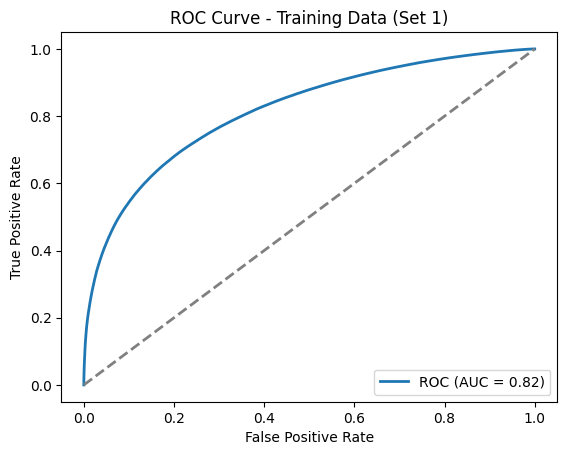

Threshold where Sensitivity = Specificity (Training Data): 0.4638
----- Training Data Metrics (Sens=Spec Threshold) -----
Train Accuracy: 0.7373
Train Confusion Matrix:
[[286627 102136]
 [174278 489068]]
Sensitivity (Recall for class 1): 0.7373
Specificity (Recall for class 0): 0.7373

========== Ensemble Metrics for Undersampled Set 2 ==========
----- Test Data Metrics (Default 0.5 Threshold) -----
Test Accuracy: 0.7178
Test Log Loss: 0.5457
Test ROC AUC: 0.7879
Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.69      0.64    166613
           1       0.80      0.73      0.77    284292

    accuracy                           0.72    450905
   macro avg       0.70      0.71      0.70    450905
weighted avg       0.73      0.72      0.72    450905

Test Confusion Matrix:
[[114819  51794]
 [ 75445 208847]]
Class 0 Test Accuracy: 0.6891
Class 1 Test Accuracy: 0.7346


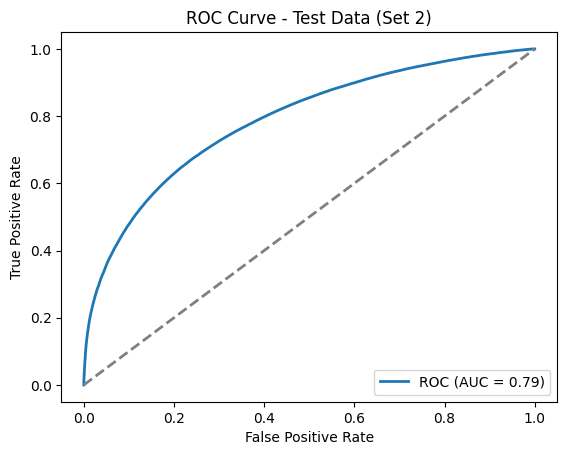

Threshold where Sensitivity = Specificity (Test Data): 0.5155
----- Test Data Metrics (Sens=Spec Threshold) -----
Test Accuracy: 0.7139
Test Confusion Matrix:
[[118950  47663]
 [ 81326 202966]]
Sensitivity (Recall for class 1): 0.7139
Specificity (Recall for class 0): 0.7139

----- Training Data Metrics (Default 0.5 Threshold) -----
Train Accuracy: 0.7266
Train Log Loss: 0.5340
Train ROC AUC: 0.8159
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307621  81142]
 [206522 456824]]
Class 0 Train Accuracy: 0.7913
Class 1 Train Accuracy: 0.6887


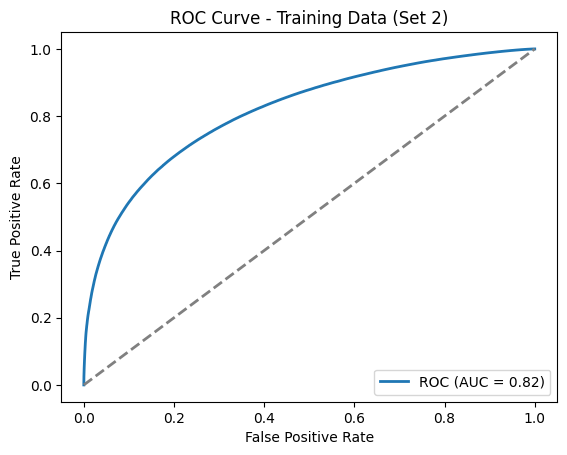

Threshold where Sensitivity = Specificity (Training Data): 0.4630
----- Training Data Metrics (Sens=Spec Threshold) -----
Train Accuracy: 0.7374
Train Confusion Matrix:
[[286682 102081]
 [174180 489166]]
Sensitivity (Recall for class 1): 0.7374
Specificity (Recall for class 0): 0.7374

========== Ensemble Metrics for Undersampled Set 3 ==========
----- Test Data Metrics (Default 0.5 Threshold) -----
Test Accuracy: 0.7168
Test Log Loss: 0.5460
Test ROC AUC: 0.7879
Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.69      0.64    166613
           1       0.80      0.73      0.77    284292

    accuracy                           0.72    450905
   macro avg       0.70      0.71      0.70    450905
weighted avg       0.73      0.72      0.72    450905

Test Confusion Matrix:
[[115041  51572]
 [ 76144 208148]]
Class 0 Test Accuracy: 0.6905
Class 1 Test Accuracy: 0.7322


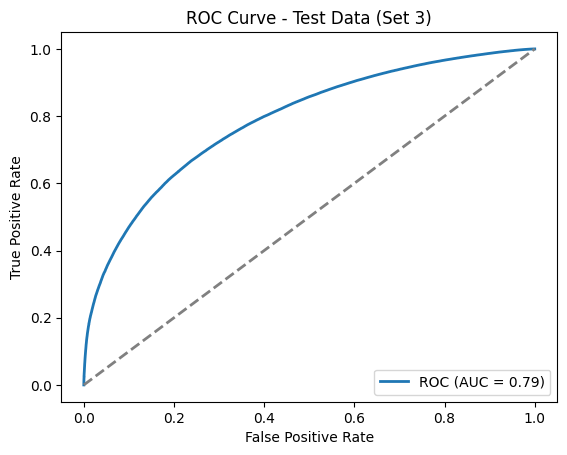

Threshold where Sensitivity = Specificity (Test Data): 0.5146
----- Test Data Metrics (Sens=Spec Threshold) -----
Test Accuracy: 0.7128
Test Confusion Matrix:
[[118757  47856]
 [ 81657 202635]]
Sensitivity (Recall for class 1): 0.7128
Specificity (Recall for class 0): 0.7128

----- Training Data Metrics (Default 0.5 Threshold) -----
Train Accuracy: 0.7267
Train Log Loss: 0.5343
Train ROC AUC: 0.8156
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307122  81641]
 [205899 457447]]
Class 0 Train Accuracy: 0.7900
Class 1 Train Accuracy: 0.6896


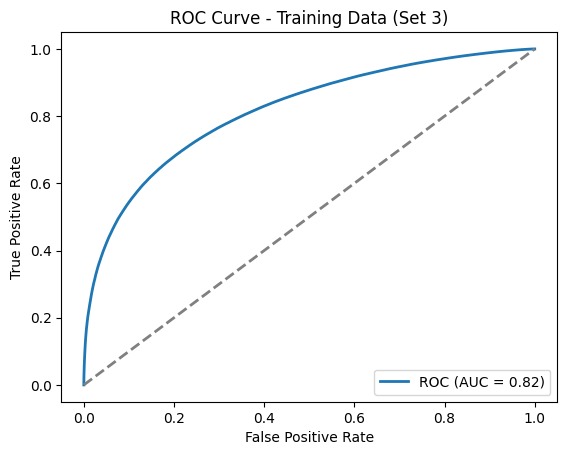

Threshold where Sensitivity = Specificity (Training Data): 0.4642
----- Training Data Metrics (Sens=Spec Threshold) -----
Train Accuracy: 0.7374
Train Confusion Matrix:
[[286687 102076]
 [174173 489173]]
Sensitivity (Recall for class 1): 0.7374
Specificity (Recall for class 0): 0.7374

========== Ensemble Metrics for Undersampled Set 4 ==========
----- Test Data Metrics (Default 0.5 Threshold) -----
Test Accuracy: 0.7202
Test Log Loss: 0.5431
Test ROC AUC: 0.7926
Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.70      0.65    166613
           1       0.81      0.73      0.77    284292

    accuracy                           0.72    450905
   macro avg       0.71      0.72      0.71    450905
weighted avg       0.73      0.72      0.72    450905

Test Confusion Matrix:
[[116768  49845]
 [ 76331 207961]]
Class 0 Test Accuracy: 0.7008
Class 1 Test Accuracy: 0.7315


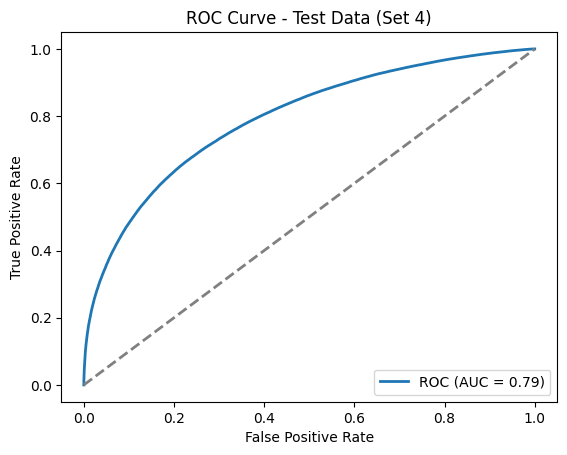

Threshold where Sensitivity = Specificity (Test Data): 0.5105
----- Test Data Metrics (Sens=Spec Threshold) -----
Test Accuracy: 0.7173
Test Confusion Matrix:
[[119514  47099]
 [ 80366 203926]]
Sensitivity (Recall for class 1): 0.7173
Specificity (Recall for class 0): 0.7173

----- Training Data Metrics (Default 0.5 Threshold) -----
Train Accuracy: 0.7270
Train Log Loss: 0.5340
Train ROC AUC: 0.8160
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307588  81175]
 [206087 457259]]
Class 0 Train Accuracy: 0.7912
Class 1 Train Accuracy: 0.6893


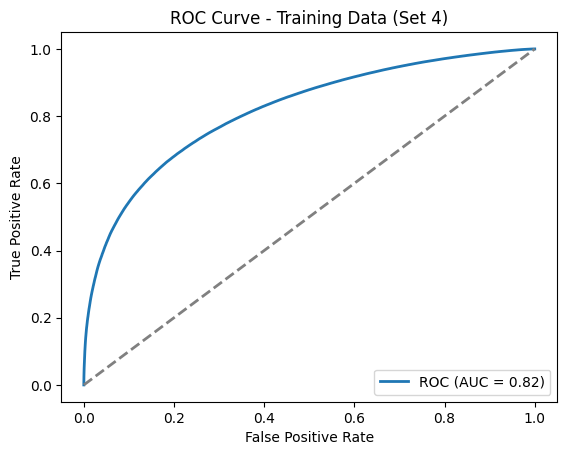

Threshold where Sensitivity = Specificity (Training Data): 0.4636
----- Training Data Metrics (Sens=Spec Threshold) -----
Train Accuracy: 0.7376
Train Confusion Matrix:
[[286753 102010]
 [174060 489286]]
Sensitivity (Recall for class 1): 0.7376
Specificity (Recall for class 0): 0.7376

========== Ensemble Metrics for Undersampled Set 5 ==========
----- Test Data Metrics (Default 0.5 Threshold) -----
Test Accuracy: 0.7201
Test Log Loss: 0.5435
Test ROC AUC: 0.7896
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.69      0.64    166613
           1       0.80      0.74      0.77    284292

    accuracy                           0.72    450905
   macro avg       0.70      0.71      0.71    450905
weighted avg       0.73      0.72      0.72    450905

Test Confusion Matrix:
[[114421  52192]
 [ 73994 210298]]
Class 0 Test Accuracy: 0.6867
Class 1 Test Accuracy: 0.7397


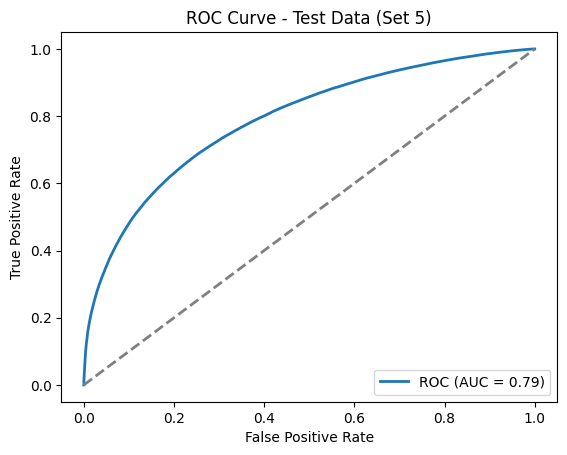

Threshold where Sensitivity = Specificity (Test Data): 0.5182
----- Test Data Metrics (Sens=Spec Threshold) -----
Test Accuracy: 0.7154
Test Confusion Matrix:
[[119201  47412]
 [ 80899 203393]]
Sensitivity (Recall for class 1): 0.7154
Specificity (Recall for class 0): 0.7154

----- Training Data Metrics (Default 0.5 Threshold) -----
Train Accuracy: 0.7264
Train Log Loss: 0.5342
Train ROC AUC: 0.8157
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307309  81454]
 [206379 456967]]
Class 0 Train Accuracy: 0.7905
Class 1 Train Accuracy: 0.6889


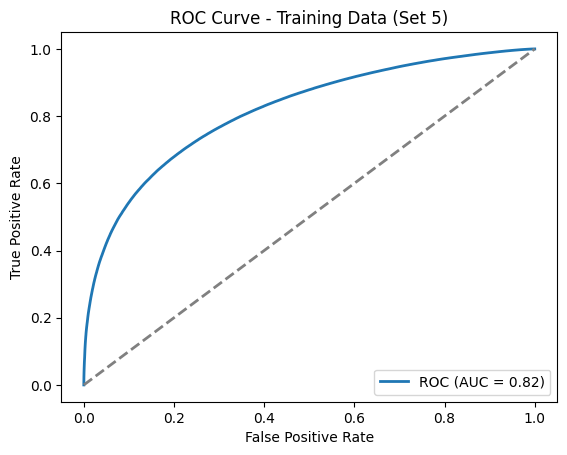

Threshold where Sensitivity = Specificity (Training Data): 0.4635
----- Training Data Metrics (Sens=Spec Threshold) -----
Train Accuracy: 0.7374
Train Confusion Matrix:
[[286687 102076]
 [174171 489175]]
Sensitivity (Recall for class 1): 0.7374
Specificity (Recall for class 0): 0.7374

========== Ensemble Metrics for Undersampled Set 6 ==========
----- Test Data Metrics (Default 0.5 Threshold) -----
Test Accuracy: 0.7191
Test Log Loss: 0.5431
Test ROC AUC: 0.7888
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.68      0.64    166613
           1       0.80      0.74      0.77    284292

    accuracy                           0.72    450905
   macro avg       0.70      0.71      0.71    450905
weighted avg       0.73      0.72      0.72    450905

Test Confusion Matrix:
[[113177  53436]
 [ 73204 211088]]
Class 0 Test Accuracy: 0.6793
Class 1 Test Accuracy: 0.7425


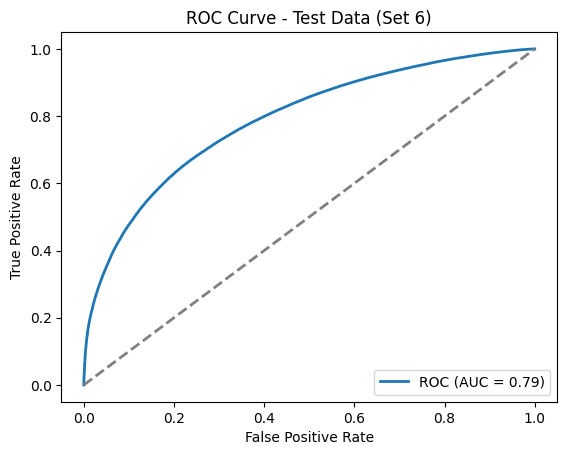

Threshold where Sensitivity = Specificity (Test Data): 0.5210
----- Test Data Metrics (Sens=Spec Threshold) -----
Test Accuracy: 0.7139
Test Confusion Matrix:
[[118948  47665]
 [ 81333 202959]]
Sensitivity (Recall for class 1): 0.7139
Specificity (Recall for class 0): 0.7139

----- Training Data Metrics (Default 0.5 Threshold) -----
Train Accuracy: 0.7270
Train Log Loss: 0.5341
Train ROC AUC: 0.8158
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307126  81637]
 [205623 457723]]
Class 0 Train Accuracy: 0.7900
Class 1 Train Accuracy: 0.6900


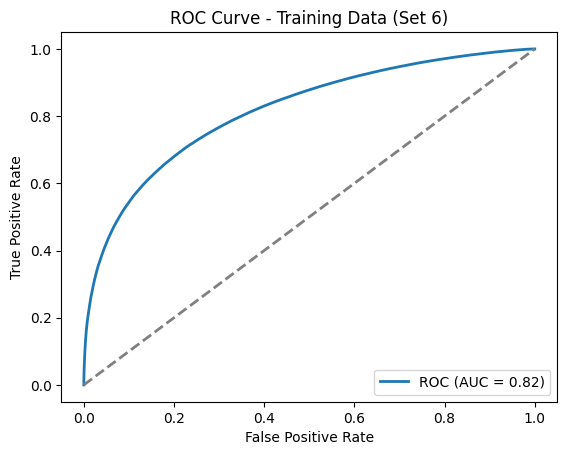

Threshold where Sensitivity = Specificity (Training Data): 0.4642
----- Training Data Metrics (Sens=Spec Threshold) -----
Train Accuracy: 0.7376
Train Confusion Matrix:
[[286771 101992]
 [174029 489317]]
Sensitivity (Recall for class 1): 0.7376
Specificity (Recall for class 0): 0.7376

========== Ensemble Metrics for Undersampled Set 7 ==========
----- Test Data Metrics (Default 0.5 Threshold) -----
Test Accuracy: 0.7242
Test Log Loss: 0.5385
Test ROC AUC: 0.7919
Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.67      0.64    166613
           1       0.79      0.76      0.78    284292

    accuracy                           0.72    450905
   macro avg       0.71      0.71      0.71    450905
weighted avg       0.73      0.72      0.73    450905

Test Confusion Matrix:
[[110856  55757]
 [ 68609 215683]]
Class 0 Test Accuracy: 0.6654
Class 1 Test Accuracy: 0.7587


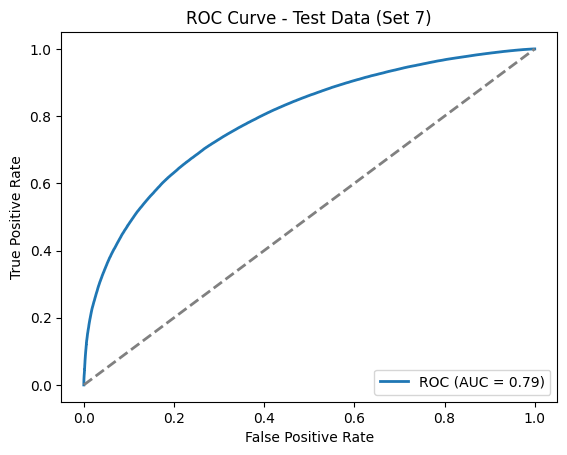

Threshold where Sensitivity = Specificity (Test Data): 0.5313
----- Test Data Metrics (Sens=Spec Threshold) -----
Test Accuracy: 0.7170
Test Confusion Matrix:
[[119453  47160]
 [ 80468 203824]]
Sensitivity (Recall for class 1): 0.7170
Specificity (Recall for class 0): 0.7169

----- Training Data Metrics (Default 0.5 Threshold) -----
Train Accuracy: 0.7269
Train Log Loss: 0.5339
Train ROC AUC: 0.8160
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68    388763
           1       0.85      0.69      0.76    663346

    accuracy                           0.73   1052109
   macro avg       0.72      0.74      0.72   1052109
weighted avg       0.76      0.73      0.73   1052109

Train Confusion Matrix:
[[307976  80787]
 [206536 456810]]
Class 0 Train Accuracy: 0.7922
Class 1 Train Accuracy: 0.6886


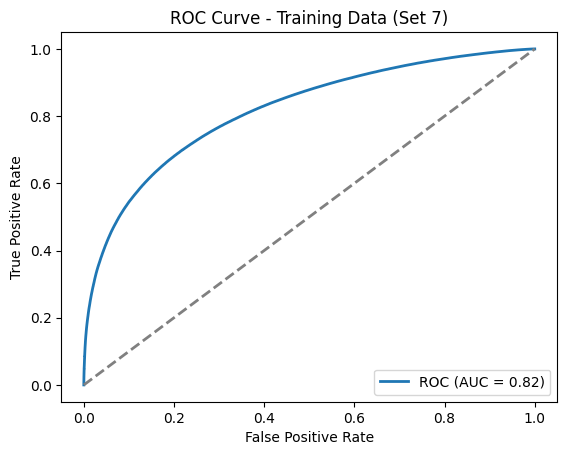

Threshold where Sensitivity = Specificity (Training Data): 0.4631
----- Training Data Metrics (Sens=Spec Threshold) -----
Train Accuracy: 0.7380
Train Confusion Matrix:
[[286921 101842]
 [173774 489572]]
Sensitivity (Recall for class 1): 0.7380
Specificity (Recall for class 0): 0.7380


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Define custom weights for ensemble
weight_1 = 0.45  # RandomForest (good for class 0)
weight_2 = 0.55  # CatBoost (good for class 1)

# Loop over 7 undersampled sets
for i in range(1, 8):
    print(f"\n========== Ensemble Metrics for Undersampled Set {i} ==========")
    
    # Get the i-th undersampled training set
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    
    # Train the two models on this undersampled set
    model_1 = RandomForestClassifier(random_state=42, max_depth=10)
    model_2 = CatBoostClassifier(depth=10, learning_rate=0.1, iterations=500, 
                                 random_seed=42, verbose=0)
    model_1.fit(X_train_set, y_train_set)
    model_2.fit(X_train_set, y_train_set)
    
    # -------------------------------
    # Evaluate on Test Data
    # -------------------------------
    # Get probability predictions on test data
    probs_1_test = model_1.predict_proba(X_test)
    probs_2_test = model_2.predict_proba(X_test)
    
    # Compute weighted probabilities for test data
    weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
    
    # Final predictions using default 0.5 threshold (argmax for binary classification)
    y_pred = np.argmax(weighted_probs_test, axis=1)
    y_pred_proba = weighted_probs_test[:, 1]  # probability for class 1
    
    # Compute metrics on test data (default threshold)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_log_loss = log_loss(y_test, y_pred_proba)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    test_report = classification_report(y_test, y_pred)
    test_conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Compute class-specific accuracy for test data
    class0_acc_test = (test_conf_matrix[0, 0] / np.sum(test_conf_matrix[0, :])
                       if np.sum(test_conf_matrix[0, :]) != 0 else 0)
    class1_acc_test = (test_conf_matrix[1, 1] / np.sum(test_conf_matrix[1, :])
                       if np.sum(test_conf_matrix[1, :]) != 0 else 0)
    
    print("----- Test Data Metrics (Default 0.5 Threshold) -----")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Log Loss: {test_log_loss:.4f}")
    print(f"Test ROC AUC: {test_roc_auc:.4f}")
    print("Test Classification Report:")
    print(test_report)
    print("Test Confusion Matrix:")
    print(test_conf_matrix)
    print(f"Class 0 Test Accuracy: {class0_acc_test:.4f}")
    print(f"Class 1 Test Accuracy: {class1_acc_test:.4f}")
    
    # Plot ROC curve for test data
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Test Data (Set {i})')
    plt.legend(loc="lower right")
    plt.show()
    
    # -------------------------------
    # Find threshold where Sensitivity equals Specificity for Test Data
    # -------------------------------
    # Specificity = 1 - FPR; so we find the threshold where |TPR - (1-FPR)| is minimized.
    sens_spec_diff = np.abs(tpr - (1 - fpr))
    sens_spec_threshold = thresholds[np.argmin(sens_spec_diff)]
    print(f"Threshold where Sensitivity = Specificity (Test Data): {sens_spec_threshold:.4f}")
    
    # Generate predictions using the new threshold
    y_pred_thresh = (y_pred_proba >= sens_spec_threshold).astype(int)
    
    # Compute metrics using the Sens=Spec threshold
    test_accuracy_thresh = accuracy_score(y_test, y_pred_thresh)
    test_conf_matrix_thresh = confusion_matrix(y_test, y_pred_thresh)
    sensitivity = test_conf_matrix_thresh[1, 1] / np.sum(test_conf_matrix_thresh[1, :])
    specificity = test_conf_matrix_thresh[0, 0] / np.sum(test_conf_matrix_thresh[0, :])
    
    print("----- Test Data Metrics (Sens=Spec Threshold) -----")
    print(f"Test Accuracy: {test_accuracy_thresh:.4f}")
    print("Test Confusion Matrix:")
    print(test_conf_matrix_thresh)
    print(f"Sensitivity (Recall for class 1): {sensitivity:.4f}")
    print(f"Specificity (Recall for class 0): {specificity:.4f}")
    
    # -------------------------------
    # Evaluate on Training Data (Full Training Set)
    # -------------------------------
    # Get probability predictions on full training data
    probs_1_train = model_1.predict_proba(X_train)
    probs_2_train = model_2.predict_proba(X_train)
    
    # Compute weighted probabilities for training data
    weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)
    
    y_train_pred = np.argmax(weighted_probs_train, axis=1)
    y_train_pred_proba = weighted_probs_train[:, 1]
    
    # Compute metrics on training data (default threshold)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_log_loss = log_loss(y_train, y_train_pred_proba)
    train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
    train_report = classification_report(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    
    # Compute class-specific accuracy for training data
    class0_acc_train = (train_conf_matrix[0, 0] / np.sum(train_conf_matrix[0, :])
                        if np.sum(train_conf_matrix[0, :]) != 0 else 0)
    class1_acc_train = (train_conf_matrix[1, 1] / np.sum(train_conf_matrix[1, :])
                        if np.sum(train_conf_matrix[1, :]) != 0 else 0)
    
    print("\n----- Training Data Metrics (Default 0.5 Threshold) -----")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Log Loss: {train_log_loss:.4f}")
    print(f"Train ROC AUC: {train_roc_auc:.4f}")
    print("Train Classification Report:")
    print(train_report)
    print("Train Confusion Matrix:")
    print(train_conf_matrix)
    print(f"Class 0 Train Accuracy: {class0_acc_train:.4f}")
    print(f"Class 1 Train Accuracy: {class1_acc_train:.4f}")
    
    # Plot ROC curve for training data
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_proba)
    plt.figure()
    plt.plot(fpr_train, tpr_train, lw=2, label=f'ROC (AUC = {train_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Training Data (Set {i})')
    plt.legend(loc="lower right")
    plt.show()
    
    # -------------------------------
    # Find threshold where Sensitivity equals Specificity for Training Data
    # -------------------------------
    sens_spec_diff_train = np.abs(tpr_train - (1 - fpr_train))
    sens_spec_threshold_train = thresholds_train[np.argmin(sens_spec_diff_train)]
    print(f"Threshold where Sensitivity = Specificity (Training Data): {sens_spec_threshold_train:.4f}")
    
    # Generate predictions using the new threshold for training data
    y_train_pred_thresh = (y_train_pred_proba >= sens_spec_threshold_train).astype(int)
    
    # Compute metrics with the new threshold for training data
    train_accuracy_thresh = accuracy_score(y_train, y_train_pred_thresh)
    train_conf_matrix_thresh = confusion_matrix(y_train, y_train_pred_thresh)
    sensitivity_train = train_conf_matrix_thresh[1, 1] / np.sum(train_conf_matrix_thresh[1, :])
    specificity_train = train_conf_matrix_thresh[0, 0] / np.sum(train_conf_matrix_thresh[0, :])
    
    print("----- Training Data Metrics (Sens=Spec Threshold) -----")
    print(f"Train Accuracy: {train_accuracy_thresh:.4f}")
    print("Train Confusion Matrix:")
    print(train_conf_matrix_thresh)
    print(f"Sensitivity (Recall for class 1): {sensitivity_train:.4f}")
    print(f"Specificity (Recall for class 0): {specificity_train:.4f}")


========== Processing Undersampled Set 1 ==========

========== Processing Undersampled Set 2 ==========

========== Processing Undersampled Set 3 ==========

========== Processing Undersampled Set 4 ==========

========== Processing Undersampled Set 5 ==========

========== Processing Undersampled Set 6 ==========

========== Processing Undersampled Set 7 ==========

===== Overall Ensemble Metrics (Default 0.5 Threshold) =====
Accuracy: 0.7235
Log Loss: 0.5402
ROC AUC: 0.7957
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.70      0.65    166613
           1       0.81      0.74      0.77    284292

    accuracy                           0.72    450905
   macro avg       0.71      0.72      0.71    450905
weighted avg       0.73      0.72      0.73    450905

Confusion Matrix:
[[115827  50786]
 [ 73889 210403]]

Threshold where Sensitivity = Specificity (Ensembled): 0.5145

===== Overall Ensemble Metrics (Sens=Spec Threshol

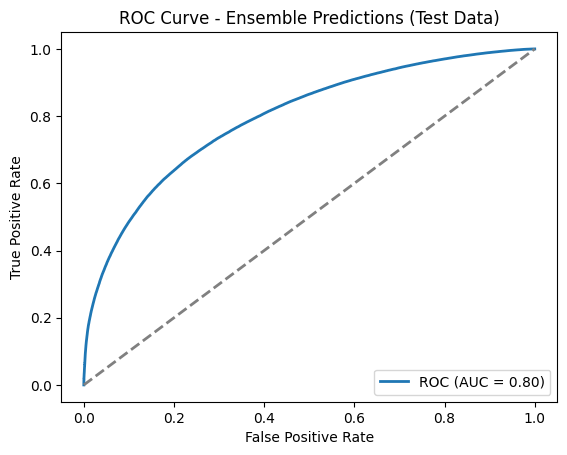

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Define custom weights for ensemble
weight_1 = 0.45  # RandomForest (good for class 0)
weight_2 = 0.55  # CatBoost (good for class 1)

# List to collect ensemble predictions on test data for each set
ensemble_probs_list = []

# Loop over 7 undersampled sets
for i in range(1, 8):
    print(f"\n========== Processing Undersampled Set {i} ==========")
    
    # Get the i-th undersampled training set
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    
    # Train the two models on this undersampled set
    model_1 = RandomForestClassifier(random_state=42, max_depth=10)
    model_2 = CatBoostClassifier(depth=10, learning_rate=0.1, iterations=500, 
                                 random_seed=42, verbose=0)
    model_1.fit(X_train_set, y_train_set)
    model_2.fit(X_train_set, y_train_set)
    
    # -------------------------------
    # Evaluate on Test Data for this set
    # -------------------------------
    probs_1_test = model_1.predict_proba(X_test)
    probs_2_test = model_2.predict_proba(X_test)
    
    # Compute weighted probabilities for test data
    weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
    
    # Save the predictions from this set for later ensembling
    ensemble_probs_list.append(weighted_probs_test)

# Combine the predictions by taking the mean across the 7 sets
ensemble_probs_test = np.mean(np.array(ensemble_probs_list), axis=0)
ensemble_y_pred = np.argmax(ensemble_probs_test, axis=1)
ensemble_y_pred_proba = ensemble_probs_test[:, 1]

# Compute overall ensemble metrics using the default threshold (0.5)
overall_accuracy = accuracy_score(y_test, ensemble_y_pred)
overall_log_loss = log_loss(y_test, ensemble_y_pred_proba)
overall_roc_auc = roc_auc_score(y_test, ensemble_y_pred_proba)
overall_report = classification_report(y_test, ensemble_y_pred)
overall_conf_matrix = confusion_matrix(y_test, ensemble_y_pred)

print("\n===== Overall Ensemble Metrics (Default 0.5 Threshold) =====")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Log Loss: {overall_log_loss:.4f}")
print(f"ROC AUC: {overall_roc_auc:.4f}")
print("Classification Report:")
print(overall_report)
print("Confusion Matrix:")
print(overall_conf_matrix)

# Optionally: Find and apply the Sensitivity=Specificity threshold on the ensembled output
fpr, tpr, thresholds = roc_curve(y_test, ensemble_y_pred_proba)
sens_spec_diff = np.abs(tpr - (1 - fpr))
sens_spec_threshold = thresholds[np.argmin(sens_spec_diff)]
print(f"\nThreshold where Sensitivity = Specificity (Ensembled): {sens_spec_threshold:.4f}")

# Generate predictions using this threshold
ensemble_y_pred_thresh = (ensemble_y_pred_proba >= sens_spec_threshold).astype(int)
overall_accuracy_thresh = accuracy_score(y_test, ensemble_y_pred_thresh)
overall_conf_matrix_thresh = confusion_matrix(y_test, ensemble_y_pred_thresh)
sensitivity = overall_conf_matrix_thresh[1, 1] / np.sum(overall_conf_matrix_thresh[1, :])
specificity = overall_conf_matrix_thresh[0, 0] / np.sum(overall_conf_matrix_thresh[0, :])

print("\n===== Overall Ensemble Metrics (Sens=Spec Threshold) =====")
print(f"Accuracy: {overall_accuracy_thresh:.4f}")
print("Confusion Matrix:")
print(overall_conf_matrix_thresh)
print(f"Sensitivity (Recall for class 1): {sensitivity:.4f}")
print(f"Specificity (Recall for class 0): {specificity:.4f}")

# Plot the ROC curve for the ensembled predictions
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {overall_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Predictions (Test Data)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Define custom weights for ensemble
weight_1 = 0.45  # RandomForest (good for class 0)
weight_2 = 0.55  # CatBoost (good for class 1)

# Lists to collect ensemble predictions on test and training data for each set
ensemble_test_probs_list = []
ensemble_train_probs_list = []

# Loop over 7 undersampled sets
for i in range(1, 8):
    print(f"\n========== Processing Undersampled Set {i} ==========")
    
    # Get the i-th undersampled training set
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    
    # Train the two models on this undersampled set
    model_1 = RandomForestClassifier(random_state=42, max_depth=10)
    model_2 = CatBoostClassifier(depth=10, learning_rate=0.1, iterations=500, 
                                 random_seed=42, verbose=0)
    model_1.fit(X_train_set, y_train_set)
    model_2.fit(X_train_set, y_train_set)
    
    # -------------------------------
    # Evaluate on Test Data for this set
    # -------------------------------
    probs_1_test = model_1.predict_proba(X_test)
    probs_2_test = model_2.predict_proba(X_test)
    # Compute weighted probabilities for test data
    weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
    # Save the test predictions for later ensembling
    ensemble_test_probs_list.append(weighted_probs_test)
    
    # -------------------------------
    # Evaluate on Training Data (Full Training Set) for this set
    # -------------------------------
    probs_1_train = model_1.predict_proba(X_train)
    probs_2_train = model_2.predict_proba(X_train)
    # Compute weighted probabilities for training data
    weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)
    # Save the training predictions for later ensembling
    ensemble_train_probs_list.append(weighted_probs_train)

# ------------------------------------------------
# Ensemble Predictions: Average Across the 7 Sets
# ------------------------------------------------

# For Test Data
ensemble_test_probs = np.mean(np.array(ensemble_test_probs_list), axis=0)
ensemble_test_y_pred = np.argmax(ensemble_test_probs, axis=1)
ensemble_test_y_pred_proba = ensemble_test_probs[:, 1]

# For Training Data
ensemble_train_probs = np.mean(np.array(ensemble_train_probs_list), axis=0)
ensemble_train_y_pred = np.argmax(ensemble_train_probs, axis=1)
ensemble_train_y_pred_proba = ensemble_train_probs[:, 1]

# ------------------------------------------------
# Evaluate Default Threshold (0.5) on Test Data
# ------------------------------------------------
overall_test_accuracy = accuracy_score(y_test, ensemble_test_y_pred)
overall_test_log_loss = log_loss(y_test, ensemble_test_y_pred_proba)
overall_test_roc_auc = roc_auc_score(y_test, ensemble_test_y_pred_proba)
overall_test_report = classification_report(y_test, ensemble_test_y_pred)
overall_test_conf_matrix = confusion_matrix(y_test, ensemble_test_y_pred)

# Compute class-specific accuracy for Test Data
class0_acc_test = (overall_test_conf_matrix[0, 0] / np.sum(overall_test_conf_matrix[0, :])
                   if np.sum(overall_test_conf_matrix[0, :]) != 0 else 0)
class1_acc_test = (overall_test_conf_matrix[1, 1] / np.sum(overall_test_conf_matrix[1, :])
                   if np.sum(overall_test_conf_matrix[1, :]) != 0 else 0)

print("\n===== Overall Ensemble Test Metrics (Default 0.5 Threshold) =====")
print(f"Accuracy: {overall_test_accuracy:.4f}")
print(f"Log Loss: {overall_test_log_loss:.4f}")
print(f"ROC AUC: {overall_test_roc_auc:.4f}")
print("Classification Report:")
print(overall_test_report)
print("Confusion Matrix:")
print(overall_test_conf_matrix)
print(f"Class 0 Accuracy: {class0_acc_test:.4f}")
print(f"Class 1 Accuracy: {class1_acc_test:.4f}")

# ------------------------------------------------
# Evaluate Default Threshold (0.5) on Training Data
# ------------------------------------------------
overall_train_accuracy = accuracy_score(y_train, ensemble_train_y_pred)
overall_train_log_loss = log_loss(y_train, ensemble_train_y_pred_proba)
overall_train_roc_auc = roc_auc_score(y_train, ensemble_train_y_pred_proba)
overall_train_report = classification_report(y_train, ensemble_train_y_pred)
overall_train_conf_matrix = confusion_matrix(y_train, ensemble_train_y_pred)

# Compute class-specific accuracy for Training Data
class0_acc_train = (overall_train_conf_matrix[0, 0] / np.sum(overall_train_conf_matrix[0, :])
                    if np.sum(overall_train_conf_matrix[0, :]) != 0 else 0)
class1_acc_train = (overall_train_conf_matrix[1, 1] / np.sum(overall_train_conf_matrix[1, :])
                    if np.sum(overall_train_conf_matrix[1, :]) != 0 else 0)

print("\n===== Overall Ensemble Training Metrics (Default 0.5 Threshold) =====")
print(f"Accuracy: {overall_train_accuracy:.4f}")
print(f"Log Loss: {overall_train_log_loss:.4f}")
print(f"ROC AUC: {overall_train_roc_auc:.4f}")
print("Classification Report:")
print(overall_train_report)
print("Confusion Matrix:")
print(overall_train_conf_matrix)
print(f"Class 0 Accuracy: {class0_acc_train:.4f}")
print(f"Class 1 Accuracy: {class1_acc_train:.4f}")

# ------------------------------------------------
# Apply MaxSens+Spec Threshold on Test Data
# ------------------------------------------------
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemble_test_y_pred_proba)
# Sensitivity = tpr and Specificity = 1 - fpr
sens_spec_sum_test = tpr_test + (1 - fpr_test)
best_index_test = np.argmax(sens_spec_sum_test)
maxsens_spec_threshold_test = thresholds_test[best_index_test]
print(f"\nThreshold (Test) maximizing Sensitivity + Specificity: {maxsens_spec_threshold_test:.4f}")

ensemble_test_y_pred_thresh = (ensemble_test_y_pred_proba >= maxsens_spec_threshold_test).astype(int)
overall_test_accuracy_thresh = accuracy_score(y_test, ensemble_test_y_pred_thresh)
overall_test_conf_matrix_thresh = confusion_matrix(y_test, ensemble_test_y_pred_thresh)
# Compute sensitivity and specificity for Test Data
sensitivity_test = overall_test_conf_matrix_thresh[1, 1] / np.sum(overall_test_conf_matrix_thresh[1, :])
specificity_test = overall_test_conf_matrix_thresh[0, 0] / np.sum(overall_test_conf_matrix_thresh[0, :])

print("\n===== Overall Ensemble Test Metrics (MaxSens+Spec Threshold) =====")
print(f"Accuracy: {overall_test_accuracy_thresh:.4f}")
print("Confusion Matrix:")
print(overall_test_conf_matrix_thresh)
print(f"Sensitivity (Recall for class 1): {sensitivity_test:.4f}")
print(f"Specificity (Recall for class 0): {specificity_test:.4f}")

# ------------------------------------------------
# Apply MaxSens+Spec Threshold on Training Data
# ------------------------------------------------
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, ensemble_train_y_pred_proba)
sens_spec_sum_train = tpr_train + (1 - fpr_train)
best_index_train = np.argmax(sens_spec_sum_train)
maxsens_spec_threshold_train = thresholds_train[best_index_train]
print(f"\nThreshold (Training) maximizing Sensitivity + Specificity: {maxsens_spec_threshold_train:.4f}")

ensemble_train_y_pred_thresh = (ensemble_train_y_pred_proba >= maxsens_spec_threshold_train).astype(int)
overall_train_accuracy_thresh = accuracy_score(y_train, ensemble_train_y_pred_thresh)
overall_train_conf_matrix_thresh = confusion_matrix(y_train, ensemble_train_y_pred_thresh)
# Compute sensitivity and specificity for Training Data
sensitivity_train = overall_train_conf_matrix_thresh[1, 1] / np.sum(overall_train_conf_matrix_thresh[1, :])
specificity_train = overall_train_conf_matrix_thresh[0, 0] / np.sum(overall_train_conf_matrix_thresh[0, :])

print("\n===== Overall Ensemble Training Metrics (MaxSens+Spec Threshold) =====")
print(f"Accuracy: {overall_train_accuracy_thresh:.4f}")
print("Confusion Matrix:")
print(overall_train_conf_matrix_thresh)
print(f"Sensitivity (Recall for class 1): {sensitivity_train:.4f}")
print(f"Specificity (Recall for class 0): {specificity_train:.4f}")

# ------------------------------------------------
# Plot the ROC Curve for the Ensemble Test Predictions
# ------------------------------------------------
plt.figure()
plt.plot(fpr_test, tpr_test, lw=2, label=f'ROC (AUC = {overall_test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Test Predictions')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Define custom weights for ensemble
weight_1 = 0.45  # RandomForest (good for class 0)
weight_2 = 0.55  # CatBoost (good for class 1)

# Lists to collect ensemble predictions on test and training data for each set
ensemble_test_probs_list = []
ensemble_train_probs_list = []

# Loop over 7 undersampled sets
for i in range(1, 8):
    print(f"\n========== Processing Undersampled Set {i} ==========")
    
    # Get the i-th undersampled training set
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    
    # Train the two models on this undersampled set
    model_1 = RandomForestClassifier(random_state=42, max_depth=10)
    model_2 = CatBoostClassifier(depth=10, learning_rate=0.1, iterations=500, 
                                 random_seed=42, verbose=0)
    model_1.fit(X_train_set, y_train_set)
    model_2.fit(X_train_set, y_train_set)
    
    # -------------------------------
    # Evaluate on Test Data for this set
    # -------------------------------
    probs_1_test = model_1.predict_proba(X_test)
    probs_2_test = model_2.predict_proba(X_test)
    # Compute weighted probabilities for test data
    weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
    # Save the test predictions for later ensembling
    ensemble_test_probs_list.append(weighted_probs_test)
    
    # -------------------------------
    # Evaluate on Training Data (Full Training Set) for this set
    # -------------------------------
    probs_1_train = model_1.predict_proba(X_train)
    probs_2_train = model_2.predict_proba(X_train)
    # Compute weighted probabilities for training data
    weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)
    # Save the training predictions for later ensembling
    ensemble_train_probs_list.append(weighted_probs_train)

# ------------------------------------------------
# Ensemble Predictions: Average Across the 7 Sets
# ------------------------------------------------

# For Test Data
ensemble_test_probs = np.mean(np.array(ensemble_test_probs_list), axis=0)
ensemble_test_y_pred = np.argmax(ensemble_test_probs, axis=1)
ensemble_test_y_pred_proba = ensemble_test_probs[:, 1]

# For Training Data
ensemble_train_probs = np.mean(np.array(ensemble_train_probs_list), axis=0)
ensemble_train_y_pred = np.argmax(ensemble_train_probs, axis=1)
ensemble_train_y_pred_proba = ensemble_train_probs[:, 1]

# ------------------------------------------------
# Evaluate Default Threshold (0.5) on Test Data
# ------------------------------------------------
overall_test_accuracy = accuracy_score(y_test, ensemble_test_y_pred)
overall_test_log_loss = log_loss(y_test, ensemble_test_y_pred_proba)
overall_test_roc_auc = roc_auc_score(y_test, ensemble_test_y_pred_proba)
overall_test_report = classification_report(y_test, ensemble_test_y_pred)
overall_test_conf_matrix = confusion_matrix(y_test, ensemble_test_y_pred)

# Compute class-specific accuracy for Test Data
class0_acc_test = (overall_test_conf_matrix[0, 0] / np.sum(overall_test_conf_matrix[0, :])
                   if np.sum(overall_test_conf_matrix[0, :]) != 0 else 0)
class1_acc_test = (overall_test_conf_matrix[1, 1] / np.sum(overall_test_conf_matrix[1, :])
                   if np.sum(overall_test_conf_matrix[1, :]) != 0 else 0)

print("\n===== Overall Ensemble Test Metrics (Default 0.5 Threshold) =====")
print(f"Accuracy: {overall_test_accuracy:.4f}")
print(f"Log Loss: {overall_test_log_loss:.4f}")
print(f"ROC AUC: {overall_test_roc_auc:.4f}")
print("Classification Report:")
print(overall_test_report)
print("Confusion Matrix:")
print(overall_test_conf_matrix)
print(f"Class 0 Accuracy: {class0_acc_test:.4f}")
print(f"Class 1 Accuracy: {class1_acc_test:.4f}")

# ------------------------------------------------
# Evaluate Default Threshold (0.5) on Training Data
# ------------------------------------------------
overall_train_accuracy = accuracy_score(y_train, ensemble_train_y_pred)
overall_train_log_loss = log_loss(y_train, ensemble_train_y_pred_proba)
overall_train_roc_auc = roc_auc_score(y_train, ensemble_train_y_pred_proba)
overall_train_report = classification_report(y_train, ensemble_train_y_pred)
overall_train_conf_matrix = confusion_matrix(y_train, ensemble_train_y_pred)

# Compute class-specific accuracy for Training Data
class0_acc_train = (overall_train_conf_matrix[0, 0] / np.sum(overall_train_conf_matrix[0, :])
                    if np.sum(overall_train_conf_matrix[0, :]) != 0 else 0)
class1_acc_train = (overall_train_conf_matrix[1, 1] / np.sum(overall_train_conf_matrix[1, :])
                    if np.sum(overall_train_conf_matrix[1, :]) != 0 else 0)

print("\n===== Overall Ensemble Training Metrics (Default 0.5 Threshold) =====")
print(f"Accuracy: {overall_train_accuracy:.4f}")
print(f"Log Loss: {overall_train_log_loss:.4f}")
print(f"ROC AUC: {overall_train_roc_auc:.4f}")
print("Classification Report:")
print(overall_train_report)
print("Confusion Matrix:")
print(overall_train_conf_matrix)
print(f"Class 0 Accuracy: {class0_acc_train:.4f}")
print(f"Class 1 Accuracy: {class1_acc_train:.4f}")

# ------------------------------------------------
# Apply MaxSens+Spec Threshold on Test Data
# ------------------------------------------------
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemble_test_y_pred_proba)
# Sensitivity = tpr and Specificity = 1 - fpr
sens_spec_sum_test = tpr_test + (1 - fpr_test)
best_index_test = np.argmax(sens_spec_sum_test)
maxsens_spec_threshold_test = thresholds_test[best_index_test]
print(f"\nThreshold (Test) maximizing Sensitivity + Specificity: {maxsens_spec_threshold_test:.4f}")

ensemble_test_y_pred_thresh = (ensemble_test_y_pred_proba >= maxsens_spec_threshold_test).astype(int)
overall_test_accuracy_thresh = accuracy_score(y_test, ensemble_test_y_pred_thresh)
overall_test_conf_matrix_thresh = confusion_matrix(y_test, ensemble_test_y_pred_thresh)
# Compute sensitivity and specificity for Test Data
sensitivity_test = overall_test_conf_matrix_thresh[1, 1] / np.sum(overall_test_conf_matrix_thresh[1, :])
specificity_test = overall_test_conf_matrix_thresh[0, 0] / np.sum(overall_test_conf_matrix_thresh[0, :])

print("\n===== Overall Ensemble Test Metrics (MaxSens+Spec Threshold) =====")
print(f"Accuracy: {overall_test_accuracy_thresh:.4f}")
print("Confusion Matrix:")
print(overall_test_conf_matrix_thresh)
print(f"Sensitivity (Recall for class 1): {sensitivity_test:.4f}")
print(f"Specificity (Recall for class 0): {specificity_test:.4f}")

# ------------------------------------------------
# Apply MaxSens+Spec Threshold on Training Data
# ------------------------------------------------
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, ensemble_train_y_pred_proba)
sens_spec_sum_train = tpr_train + (1 - fpr_train)
best_index_train = np.argmax(sens_spec_sum_train)
maxsens_spec_threshold_train = thresholds_train[best_index_train]
print(f"\nThreshold (Training) maximizing Sensitivity + Specificity: {maxsens_spec_threshold_train:.4f}")

ensemble_train_y_pred_thresh = (ensemble_train_y_pred_proba >= maxsens_spec_threshold_train).astype(int)
overall_train_accuracy_thresh = accuracy_score(y_train, ensemble_train_y_pred_thresh)
overall_train_conf_matrix_thresh = confusion_matrix(y_train, ensemble_train_y_pred_thresh)
# Compute sensitivity and specificity for Training Data
sensitivity_train = overall_train_conf_matrix_thresh[1, 1] / np.sum(overall_train_conf_matrix_thresh[1, :])
specificity_train = overall_train_conf_matrix_thresh[0, 0] / np.sum(overall_train_conf_matrix_thresh[0, :])

print("\n===== Overall Ensemble Training Metrics (MaxSens+Spec Threshold) =====")
print(f"Accuracy: {overall_train_accuracy_thresh:.4f}")
print("Confusion Matrix:")
print(overall_train_conf_matrix_thresh)
print(f"Sensitivity (Recall for class 1): {sensitivity_train:.4f}")
print(f"Specificity (Recall for class 0): {specificity_train:.4f}")

# ------------------------------------------------
# Apply MaxPCC Threshold on Test Data
# ------------------------------------------------
# MaxPCC: Maximize overall accuracy (Percentage of Correct Classifications)
possible_thresholds = np.linspace(0, 1, 101)
accuracies_test = []
for thresh in possible_thresholds:
    preds = (ensemble_test_y_pred_proba >= thresh).astype(int)
    accuracies_test.append(accuracy_score(y_test, preds))
maxpcc_threshold_test = possible_thresholds[np.argmax(accuracies_test)]
maxpcc_accuracy_test = np.max(accuracies_test)
ensemble_test_y_pred_maxpcc = (ensemble_test_y_pred_proba >= maxpcc_threshold_test).astype(int)
conf_matrix_maxpcc_test = confusion_matrix(y_test, ensemble_test_y_pred_maxpcc)

print(f"\nThreshold (Test) maximizing Percentage of Correct Classifications: {maxpcc_threshold_test:.4f}")
print(f"Accuracy (Test) at MaxPCC threshold: {maxpcc_accuracy_test:.4f}")
print("Confusion Matrix (Test):")
print(conf_matrix_maxpcc_test)

# ------------------------------------------------
# Apply MaxPCC Threshold on Training Data
# ------------------------------------------------
possible_thresholds_train = np.linspace(0, 1, 101)
accuracies_train = []
for thresh in possible_thresholds_train:
    preds = (ensemble_train_y_pred_proba >= thresh).astype(int)
    accuracies_train.append(accuracy_score(y_train, preds))
maxpcc_threshold_train = possible_thresholds_train[np.argmax(accuracies_train)]
maxpcc_accuracy_train = np.max(accuracies_train)
ensemble_train_y_pred_maxpcc = (ensemble_train_y_pred_proba >= maxpcc_threshold_train).astype(int)
conf_matrix_maxpcc_train = confusion_matrix(y_train, ensemble_train_y_pred_maxpcc)

print(f"\nThreshold (Training) maximizing Percentage of Correct Classifications: {maxpcc_threshold_train:.4f}")
print(f"Accuracy (Training) at MaxPCC threshold: {maxpcc_accuracy_train:.4f}")
print("Confusion Matrix (Training):")
print(conf_matrix_maxpcc_train)

# ------------------------------------------------
# Plot the ROC Curve for the Ensemble Test Predictions
# ------------------------------------------------
plt.figure()
plt.plot(fpr_test, tpr_test, lw=2, label=f'ROC (AUC = {overall_test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Test Predictions')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Define custom weights for ensemble
weight_1 = 0.45  # RandomForest (good for class 0)
weight_2 = 0.55  # CatBoost (good for class 1)

# Lists to collect ensemble predictions on test and training data for each set
ensemble_test_probs_list = []
ensemble_train_probs_list = []

# Loop over 7 undersampled sets
for i in range(1, 8):
    print(f"\n========== Processing Undersampled Set {i} ==========")
    
    # Get the i-th undersampled training set
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    
    # Train the two models on this undersampled set
    model_1 = RandomForestClassifier(random_state=42, max_depth=10)
    model_2 = CatBoostClassifier(depth=10, learning_rate=0.1, iterations=500, 
                                 random_seed=42, verbose=0)
    model_1.fit(X_train_set, y_train_set)
    model_2.fit(X_train_set, y_train_set)
    
    # -------------------------------
    # Evaluate on Test Data for this set
    # -------------------------------
    probs_1_test = model_1.predict_proba(X_test)
    probs_2_test = model_2.predict_proba(X_test)
    # Compute weighted probabilities for test data
    weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
    # Save the test predictions for later ensembling
    ensemble_test_probs_list.append(weighted_probs_test)
    
    # -------------------------------
    # Evaluate on Training Data (Full Training Set) for this set
    # -------------------------------
    probs_1_train = model_1.predict_proba(X_train)
    probs_2_train = model_2.predict_proba(X_train)
    # Compute weighted probabilities for training data
    weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)
    # Save the training predictions for later ensembling
    ensemble_train_probs_list.append(weighted_probs_train)

# ------------------------------------------------
# Ensemble Predictions: Average Across the 7 Sets
# ------------------------------------------------

# For Test Data
ensemble_test_probs = np.mean(np.array(ensemble_test_probs_list), axis=0)
ensemble_test_y_pred = np.argmax(ensemble_test_probs, axis=1)
ensemble_test_y_pred_proba = ensemble_test_probs[:, 1]

# For Training Data
ensemble_train_probs = np.mean(np.array(ensemble_train_probs_list), axis=0)
ensemble_train_y_pred = np.argmax(ensemble_train_probs, axis=1)
ensemble_train_y_pred_proba = ensemble_train_probs[:, 1]

# ------------------------------------------------
# Evaluate Default Threshold (0.5) on Test Data
# ------------------------------------------------
overall_test_accuracy = accuracy_score(y_test, ensemble_test_y_pred)
overall_test_log_loss = log_loss(y_test, ensemble_test_y_pred_proba)
overall_test_roc_auc = roc_auc_score(y_test, ensemble_test_y_pred_proba)
overall_test_report = classification_report(y_test, ensemble_test_y_pred)
overall_test_conf_matrix = confusion_matrix(y_test, ensemble_test_y_pred)

# Compute class-specific accuracy for Test Data
class0_acc_test = (overall_test_conf_matrix[0, 0] / np.sum(overall_test_conf_matrix[0, :])
                   if np.sum(overall_test_conf_matrix[0, :]) != 0 else 0)
class1_acc_test = (overall_test_conf_matrix[1, 1] / np.sum(overall_test_conf_matrix[1, :])
                   if np.sum(overall_test_conf_matrix[1, :]) != 0 else 0)

print("\n===== Overall Ensemble Test Metrics (Default 0.5 Threshold) =====")
print(f"Accuracy: {overall_test_accuracy:.4f}")
print(f"Log Loss: {overall_test_log_loss:.4f}")
print(f"ROC AUC: {overall_test_roc_auc:.4f}")
print("Classification Report:")
print(overall_test_report)
print("Confusion Matrix:")
print(overall_test_conf_matrix)
print(f"Class 0 Accuracy: {class0_acc_test:.4f}")
print(f"Class 1 Accuracy: {class1_acc_test:.4f}")

# ------------------------------------------------
# Evaluate Default Threshold (0.5) on Training Data
# ------------------------------------------------
overall_train_accuracy = accuracy_score(y_train, ensemble_train_y_pred)
overall_train_log_loss = log_loss(y_train, ensemble_train_y_pred_proba)
overall_train_roc_auc = roc_auc_score(y_train, ensemble_train_y_pred_proba)
overall_train_report = classification_report(y_train, ensemble_train_y_pred)
overall_train_conf_matrix = confusion_matrix(y_train, ensemble_train_y_pred)

# Compute class-specific accuracy for Training Data
class0_acc_train = (overall_train_conf_matrix[0, 0] / np.sum(overall_train_conf_matrix[0, :])
                    if np.sum(overall_train_conf_matrix[0, :]) != 0 else 0)
class1_acc_train = (overall_train_conf_matrix[1, 1] / np.sum(overall_train_conf_matrix[1, :])
                    if np.sum(overall_train_conf_matrix[1, :]) != 0 else 0)

print("\n===== Overall Ensemble Training Metrics (Default 0.5 Threshold) =====")
print(f"Accuracy: {overall_train_accuracy:.4f}")
print(f"Log Loss: {overall_train_log_loss:.4f}")
print(f"ROC AUC: {overall_train_roc_auc:.4f}")
print("Classification Report:")
print(overall_train_report)
print("Confusion Matrix:")
print(overall_train_conf_matrix)
print(f"Class 0 Accuracy: {class0_acc_train:.4f}")
print(f"Class 1 Accuracy: {class1_acc_train:.4f}")

# ------------------------------------------------
# Apply MaxSens+Spec Threshold on Test Data
# ------------------------------------------------
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemble_test_y_pred_proba)
# Sensitivity = tpr and Specificity = 1 - fpr
sens_spec_sum_test = tpr_test + (1 - fpr_test)
best_index_test = np.argmax(sens_spec_sum_test)
maxsens_spec_threshold_test = thresholds_test[best_index_test]
print(f"\nThreshold (Test) maximizing Sensitivity + Specificity: {maxsens_spec_threshold_test:.4f}")

ensemble_test_y_pred_thresh = (ensemble_test_y_pred_proba >= maxsens_spec_threshold_test).astype(int)
overall_test_accuracy_thresh = accuracy_score(y_test, ensemble_test_y_pred_thresh)
overall_test_conf_matrix_thresh = confusion_matrix(y_test, ensemble_test_y_pred_thresh)
# Compute sensitivity and specificity for Test Data
sensitivity_test = overall_test_conf_matrix_thresh[1, 1] / np.sum(overall_test_conf_matrix_thresh[1, :])
specificity_test = overall_test_conf_matrix_thresh[0, 0] / np.sum(overall_test_conf_matrix_thresh[0, :])

print("\n===== Overall Ensemble Test Metrics (MaxSens+Spec Threshold) =====")
print(f"Accuracy: {overall_test_accuracy_thresh:.4f}")
print("Confusion Matrix:")
print(overall_test_conf_matrix_thresh)
print(f"Sensitivity (Recall for class 1): {sensitivity_test:.4f}")
print(f"Specificity (Recall for class 0): {specificity_test:.4f}")

# ------------------------------------------------
# Apply MaxSens+Spec Threshold on Training Data
# ------------------------------------------------
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, ensemble_train_y_pred_proba)
sens_spec_sum_train = tpr_train + (1 - fpr_train)
best_index_train = np.argmax(sens_spec_sum_train)
maxsens_spec_threshold_train = thresholds_train[best_index_train]
print(f"\nThreshold (Training) maximizing Sensitivity + Specificity: {maxsens_spec_threshold_train:.4f}")

ensemble_train_y_pred_thresh = (ensemble_train_y_pred_proba >= maxsens_spec_threshold_train).astype(int)
overall_train_accuracy_thresh = accuracy_score(y_train, ensemble_train_y_pred_thresh)
overall_train_conf_matrix_thresh = confusion_matrix(y_train, ensemble_train_y_pred_thresh)
# Compute sensitivity and specificity for Training Data
sensitivity_train = overall_train_conf_matrix_thresh[1, 1] / np.sum(overall_train_conf_matrix_thresh[1, :])
specificity_train = overall_train_conf_matrix_thresh[0, 0] / np.sum(overall_train_conf_matrix_thresh[0, :])

print("\n===== Overall Ensemble Training Metrics (MaxSens+Spec Threshold) =====")
print(f"Accuracy: {overall_train_accuracy_thresh:.4f}")
print("Confusion Matrix:")
print(overall_train_conf_matrix_thresh)
print(f"Sensitivity (Recall for class 1): {sensitivity_train:.4f}")
print(f"Specificity (Recall for class 0): {specificity_train:.4f}")

# ------------------------------------------------
# Apply MaxPCC Threshold on Test Data
# ------------------------------------------------
possible_thresholds = np.linspace(0, 1, 101)
accuracies_test = []
for thresh in possible_thresholds:
    preds = (ensemble_test_y_pred_proba >= thresh).astype(int)
    accuracies_test.append(accuracy_score(y_test, preds))
maxpcc_threshold_test = possible_thresholds[np.argmax(accuracies_test)]
maxpcc_accuracy_test = np.max(accuracies_test)
ensemble_test_y_pred_maxpcc = (ensemble_test_y_pred_proba >= maxpcc_threshold_test).astype(int)
conf_matrix_maxpcc_test = confusion_matrix(y_test, ensemble_test_y_pred_maxpcc)

print(f"\nThreshold (Test) maximizing Percentage of Correct Classifications (MaxPCC): {maxpcc_threshold_test:.4f}")
print(f"Accuracy (Test) at MaxPCC threshold: {maxpcc_accuracy_test:.4f}")
print("Confusion Matrix (Test):")
print(conf_matrix_maxpcc_test)

# ------------------------------------------------
# Apply MaxPCC Threshold on Training Data
# ------------------------------------------------
possible_thresholds_train = np.linspace(0, 1, 101)
accuracies_train = []
for thresh in possible_thresholds_train:
    preds = (ensemble_train_y_pred_proba >= thresh).astype(int)
    accuracies_train.append(accuracy_score(y_train, preds))
maxpcc_threshold_train = possible_thresholds_train[np.argmax(accuracies_train)]
maxpcc_accuracy_train = np.max(accuracies_train)
ensemble_train_y_pred_maxpcc = (ensemble_train_y_pred_proba >= maxpcc_threshold_train).astype(int)
conf_matrix_maxpcc_train = confusion_matrix(y_train, ensemble_train_y_pred_maxpcc)

print(f"\nThreshold (Training) maximizing Percentage of Correct Classifications (MaxPCC): {maxpcc_threshold_train:.4f}")
print(f"Accuracy (Training) at MaxPCC threshold: {maxpcc_accuracy_train:.4f}")
print("Confusion Matrix (Training):")
print(conf_matrix_maxpcc_train)

# ------------------------------------------------
# Apply PredPrev = ObsPrev Threshold on Test Data
# ------------------------------------------------
# Calculate observed prevalence (churn rate) in the test set
obs_prev_test = np.mean(y_test)  # fraction of churn cases (class 1)
# Use np.percentile to get the threshold such that (100*(1-obs_prev_test))% of predicted probabilities lie below it.
threshold_prev_test = np.percentile(ensemble_test_y_pred_proba, 100 * (1 - obs_prev_test))
ensemble_test_y_pred_prevprev = (ensemble_test_y_pred_proba >= threshold_prev_test).astype(int)
conf_matrix_prevprev_test = confusion_matrix(y_test, ensemble_test_y_pred_prevprev)
accuracy_prevprev_test = accuracy_score(y_test, ensemble_test_y_pred_prevprev)

print("\n===== Overall Ensemble Test Metrics (PredPrev = ObsPrev Threshold) =====")
print(f"Observed Prevalence (Test): {obs_prev_test:.4f}")
print(f"Threshold (Test) matching predicted prevalence to observed prevalence: {threshold_prev_test:.4f}")
print(f"Accuracy (Test) at PredPrev threshold: {accuracy_prevprev_test:.4f}")
print("Confusion Matrix (Test):")
print(conf_matrix_prevprev_test)

# ------------------------------------------------
# Apply PredPrev = ObsPrev Threshold on Training Data
# ------------------------------------------------
obs_prev_train = np.mean(y_train)
threshold_prev_train = np.percentile(ensemble_train_y_pred_proba, 100 * (1 - obs_prev_train))
ensemble_train_y_pred_prevprev = (ensemble_train_y_pred_proba >= threshold_prev_train).astype(int)
conf_matrix_prevprev_train = confusion_matrix(y_train, ensemble_train_y_pred_prevprev)
accuracy_prevprev_train = accuracy_score(y_train, ensemble_train_y_pred_prevprev)

print("\n===== Overall Ensemble Training Metrics (PredPrev = ObsPrev Threshold) =====")
print(f"Observed Prevalence (Training): {obs_prev_train:.4f}")
print(f"Threshold (Training) matching predicted prevalence to observed prevalence: {threshold_prev_train:.4f}")
print(f"Accuracy (Training) at PredPrev threshold: {accuracy_prevprev_train:.4f}")
print("Confusion Matrix (Training):")
print(conf_matrix_prevprev_train)

# ------------------------------------------------
# Plot the ROC Curve for the Ensemble Test Predictions
# ------------------------------------------------
plt.figure()
plt.plot(fpr_test, tpr_test, lw=2, label=f'ROC (AUC = {overall_test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Test Predictions')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Define custom weights for ensemble
weight_1 = 0.45  # RandomForest (good for class 0)
weight_2 = 0.55  # CatBoost (good for class 1)

# Lists to collect ensemble predictions on test and training data for each set
ensemble_test_probs_list = []
ensemble_train_probs_list = []

# Loop over 7 undersampled sets
for i in range(1, 8):
    print(f"\n========== Processing Undersampled Set {i} ==========")
    
    # Get the i-th undersampled training set
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    
    # Train the two models on this undersampled set
    model_1 = RandomForestClassifier(random_state=42, max_depth=10)
    model_2 = CatBoostClassifier(depth=10, learning_rate=0.1, iterations=500, 
                                 random_seed=42, verbose=0)
    model_1.fit(X_train_set, y_train_set)
    model_2.fit(X_train_set, y_train_set)
    
    # -------------------------------
    # Evaluate on Test Data for this set
    # -------------------------------
    probs_1_test = model_1.predict_proba(X_test)
    probs_2_test = model_2.predict_proba(X_test)
    weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
    ensemble_test_probs_list.append(weighted_probs_test)
    
    # -------------------------------
    # Evaluate on Training Data (Full Training Set) for this set
    # -------------------------------
    probs_1_train = model_1.predict_proba(X_train)
    probs_2_train = model_2.predict_proba(X_train)
    weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)
    ensemble_train_probs_list.append(weighted_probs_train)

# ------------------------------------------------
# Ensemble Predictions: Average Across the 7 Sets
# ------------------------------------------------
# For Test Data
ensemble_test_probs = np.mean(np.array(ensemble_test_probs_list), axis=0)
ensemble_test_y_pred_proba = ensemble_test_probs[:, 1]  # Probability for class 1

# For Training Data
ensemble_train_probs = np.mean(np.array(ensemble_train_probs_list), axis=0)
ensemble_train_y_pred_proba = ensemble_train_probs[:, 1]  # Probability for class 1

# ------------------------------------------------
# MinROCdist Threshold on Test Data
# ------------------------------------------------
# Compute the ROC curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemble_test_y_pred_proba)

# Calculate the Euclidean distance from each ROC point to the perfect point (0,1)
distances_test = np.sqrt(fpr_test**2 + (1 - tpr_test)**2)
min_roc_dist_index_test = np.argmin(distances_test)
min_roc_dist_threshold_test = thresholds_test[min_roc_dist_index_test]

# Generate predictions using the MinROCdist threshold
ensemble_test_y_pred_minroc = (ensemble_test_y_pred_proba >= min_roc_dist_threshold_test).astype(int)
overall_test_accuracy_minroc = accuracy_score(y_test, ensemble_test_y_pred_minroc)
conf_matrix_minroc_test = confusion_matrix(y_test, ensemble_test_y_pred_minroc)

print(f"\nThreshold (Test) minimizing distance to perfect ROC (MinROCdist): {min_roc_dist_threshold_test:.4f}")
print("\n===== Ensemble Test Metrics (MinROCdist Threshold) =====")
print(f"Accuracy: {overall_test_accuracy_minroc:.4f}")
print("Confusion Matrix:")
print(conf_matrix_minroc_test)

# Optionally, plot the ROC curve along with the perfect point
plt.figure()
plt.plot(fpr_test, tpr_test, lw=2, label=f'ROC (AUC = {roc_auc_score(y_test, ensemble_test_y_pred_proba):.2f})')
plt.scatter(fpr_test[min_roc_dist_index_test], tpr_test[min_roc_dist_index_test],
            color='red', label=f'MinROCdist Threshold: {min_roc_dist_threshold_test:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with MinROCdist Threshold (Test Data)')
plt.legend(loc="lower right")
plt.show()

# ------------------------------------------------
# MinROCdist Threshold on Training Data
# ------------------------------------------------
# Compute the ROC curve for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, ensemble_train_y_pred_proba)

# Calculate distances to the perfect ROC point (0,1)
distances_train = np.sqrt(fpr_train**2 + (1 - tpr_train)**2)
min_roc_dist_index_train = np.argmin(distances_train)
min_roc_dist_threshold_train = thresholds_train[min_roc_dist_index_train]

# Generate predictions using the MinROCdist threshold for training data
ensemble_train_y_pred_minroc = (ensemble_train_y_pred_proba >= min_roc_dist_threshold_train).astype(int)
overall_train_accuracy_minroc = accuracy_score(y_train, ensemble_train_y_pred_minroc)
conf_matrix_minroc_train = confusion_matrix(y_train, ensemble_train_y_pred_minroc)

print(f"\nThreshold (Training) minimizing distance to perfect ROC (MinROCdist): {min_roc_dist_threshold_train:.4f}")
print("\n===== Ensemble Training Metrics (MinROCdist Threshold) =====")
print(f"Accuracy: {overall_train_accuracy_minroc:.4f}")
print("Confusion Matrix:")
print(conf_matrix_minroc_train)